In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

az.style.use("arviz-darkgrid")

CHERRY_BLOSSOMS_DATA_LOCATION = '../../data/cherry_blossoms.csv' 

### Code 4.72

In [2]:
df = pd.read_csv(CHERRY_BLOSSOMS_DATA_LOCATION)

df.head()

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN


In [3]:
df = df.dropna(subset=['temp'])

df.describe()

,year,doy,temp,temp_upper,temp_lower
count,1124.000000,787.00000,1124.000000,1124.000000,1124.000000
mean,1418.243772,104.92122,6.141886,7.185151,5.098941
std,325.058651,6.25773,0.663648,0.992921,0.850350
min,839.000000,86.00000,4.670000,5.450000,0.750000
25%,1137.750000,101.00000,5.700000,6.480000,4.610000
50%,1418.500000,105.00000,6.100000,7.040000,5.145000
75%,1699.250000,109.00000,6.530000,7.720000,5.542500
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [4]:
# convert to a dict of lists
cherry_dict = df.to_dict(orient='list')

az.summary(cherry_dict, kind='stats', hdi_prob=0.89, skipna=True)

,mean,sd,hdi_5.5%,hdi_94.5%
year,1418.244,325.059,876.00,1876.00
doy,104.921,6.258,95.00,114.00
temp,6.142,0.664,5.03,7.13
temp_upper,7.185,0.993,5.66,8.54
temp_lower,5.099,0.850,3.79,6.37


### Plot Temperature vs Year

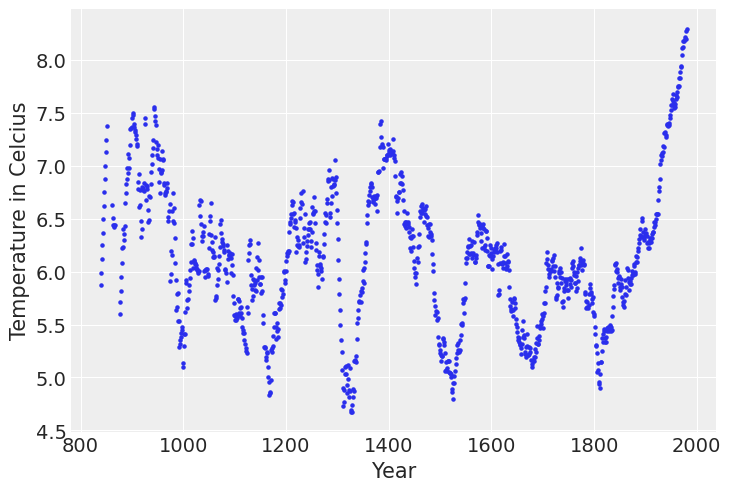

In [5]:
df.plot.scatter(x='year', y='temp', marker='.')

plt.xlabel('Year')
plt.ylabel('Temperature in Celcius')

plt.show()

## Building a B-Spline

We use the `patsy` library for generating B-splines. 

_From the docs_ at https://patsy.readthedocs.io/en/latest/spline-regression.html: 

B-spline bases can be generated with the `bs()` stateful transform. The spline bases returned by `bs()` are designed to be compatible with those produced by the R `bs` function. 

```python
import matplotlib.pyplot as plt

plt.title("B-spline basis example (degree=3)");

x = np.linspace(0., 1., 100)

y = dmatrix("bs(x, df=6, degree=3, include_intercept=True) - 1", {"x": x})

# Define some coefficients
b = np.array([1.3, 0.6, 0.9, 0.4, 1.6, 0.7])

# Plot B-spline basis functions (colored curves) each multiplied by its coeff
plt.plot(x, y * b);

# Plot the spline itself (sum of the basis functions, thick black curve)
plt.plot(x, np.dot(y, b), color='k', linewidth=3);
```

### Creating Cubic Basis Functions

### Code 4.73, 4.74 and 4.75

In [6]:
num_knots = 15
knot_list = np.quantile(df['year'], np.linspace(0, 1, num_knots))

In [7]:
from patsy import dmatrix

B = dmatrix("bs(year, knots=knots, degree=3, include_intercept=True) - 1", 
            {"year": df['year'], 
             "knots": knot_list[1:-1]})

In [8]:
type(B)

patsy.design_info.DesignMatrix

In [9]:
B.shape

(1124, 17)

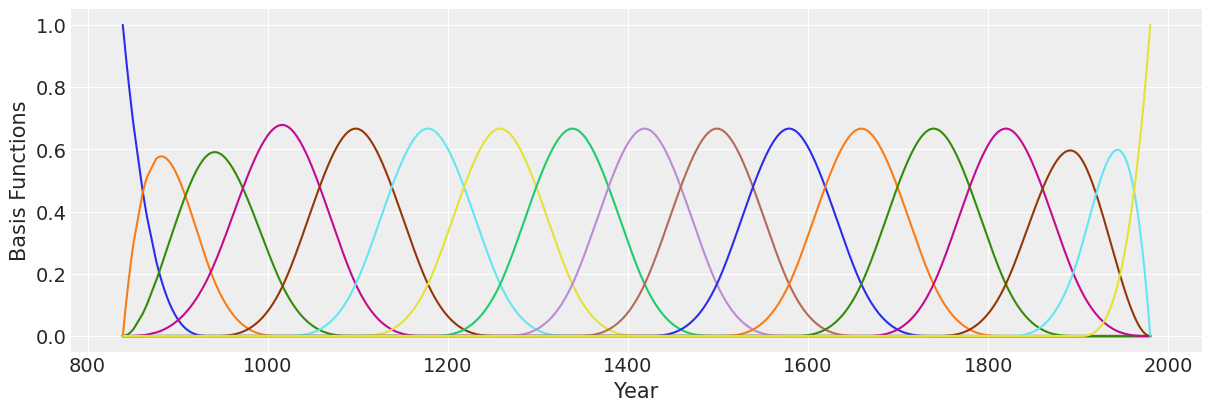

In [10]:
ncols = B.shape[1]

_, ax = plt.subplots(1, 1, figsize=(12, 4))

for i in range(ncols):
    ax.plot(df['year'], B[:, i])

ax.set_xlabel('Year')
ax.set_ylabel('Basis Functions')

plt.show()

### Creating Weights for the Basis Functions 

To build the set of weights for the basis functions, we fit a linear regression model with the basis functions as predictors. We include an intercept term so that the weights of the basis function can be interpreted as deviations from the intercept.

The model that we will be fitting is given by:
$$
\begin{align*}
    T_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \sum_{k} w_{k} \cdot B_{i k} \\
    \alpha  & \sim N(6, 10) \\
    w_k     & \sim N(0, 1) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 4.76

In [11]:
B = np.asarray(B)

with pm.Model() as m_4_7:
    alpha = pm.Normal('alpha', mu=6, sigma=10)
    w = pm.Normal('w', mu=0, sigma=1, shape=B.shape[1])
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + pm.math.dot(B, w))
    
    T = pm.Normal('temp', mu=mu, sigma=sigma, observed=df['temp'])
    
    trace_4_7 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 303 seconds.
There were 3655 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5987991271043802, but should be close to 0.8. Try to increase the number of tuning steps.
There were 380 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
trace_4_7.varnames

['alpha', 'w', 'sigma_log__', 'sigma', 'mu']

In [13]:
df_trace = pm.trace_to_dataframe(trace_4_7)
df_trace.filter(regex=('w.*')).head()

,w__0,w__1,w__2,w__3,w__4,w__5,w__6,w__7,w__8,w__9,w__10,w__11,w__12,w__13,w__14,w__15,w__16
0,0.045576,-0.284242,1.189748,-1.133019,-0.093497,-1.658381,0.938817,-2.091110,2.007079,-2.375261,0.599295,-1.854237,-0.079169,-1.389847,-0.261017,0.817059,1.768381
1,-0.332371,0.207690,0.686008,-1.065485,-0.300432,-1.734559,0.775123,-2.287533,2.078688,-2.671854,0.536584,-1.914367,-0.089212,-1.746375,-0.215742,0.653457,1.750581
2,-0.307530,0.241662,0.659619,-1.096657,-0.256823,-1.759799,0.703127,-2.202304,2.069343,-2.681367,0.603311,-1.885008,-0.079772,-1.755579,-0.210038,0.682647,1.740888
3,-0.013029,0.119359,1.289846,-0.913076,0.165988,-1.451821,1.154423,-1.924341,2.386966,-2.296149,0.942269,-1.635757,0.260394,-1.325894,0.093536,1.106546,2.030004
4,0.188681,0.206232,1.310930,-0.878637,0.050690,-1.391243,1.112060,-1.861148,2.335803,-2.276482,0.951332,-1.622200,0.128029,-1.124052,0.062609,1.042106,1.852339


In [14]:
df_trace.filter(regex=('mu.*')).head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__1114,mu__1115,mu__1116,mu__1117,mu__1118,mu__1119,mu__1120,mu__1121,mu__1122,mu__1123
0,6.588967,6.579246,6.570221,6.561879,6.554208,6.547194,6.540825,6.535086,6.529966,6.525450,...,8.006661,8.039112,8.071916,8.105078,8.138601,8.172489,8.206747,8.241377,8.276384,8.311772
1,6.327287,6.343697,6.359934,6.375995,6.391880,6.407586,6.423114,6.438460,6.453623,6.468602,...,8.064981,8.101057,8.137685,8.174873,8.212631,8.250966,8.289886,8.329400,8.369515,8.410240
2,6.347748,6.364424,6.380900,6.397176,6.413250,6.429120,6.444787,6.460249,6.475504,6.490552,...,8.062160,8.097160,8.132670,8.168698,8.205252,8.242339,8.279966,8.318142,8.356872,8.396166
3,6.297203,6.301404,6.305916,6.310729,6.315836,6.321227,6.326894,6.332830,6.339025,6.345472,...,8.044582,8.075983,8.107735,8.139843,8.172313,8.205147,8.238352,8.271932,8.305892,8.340235
4,6.529068,6.529786,6.530863,6.532290,6.534057,6.536157,6.538581,6.541319,6.544363,6.547705,...,7.931720,7.959598,7.987748,8.016176,8.044883,8.073873,8.103149,8.132714,8.162572,8.192726


In [15]:
df_w = df_trace.filter(regex='w.*')
w_means = df_w.apply(np.mean, axis=0).values

w_means

array([ 0.09433577,  0.24951685,  1.19297592, -0.81573068,  0.09989382,
       -1.39983805,  1.15636291, -1.91315011,  2.34858162, -2.3191732 ,
        0.93735779, -1.6116999 ,  0.17995464, -1.23786352,  0.0327928 ,
        0.99684766,  2.0382342 ])

In [16]:
df_w['w__0'].mean(), df_w['w__1'].mean()

(0.09433576996951917, 0.24951684807588376)

### Plotting the Weighted Basis Functions 

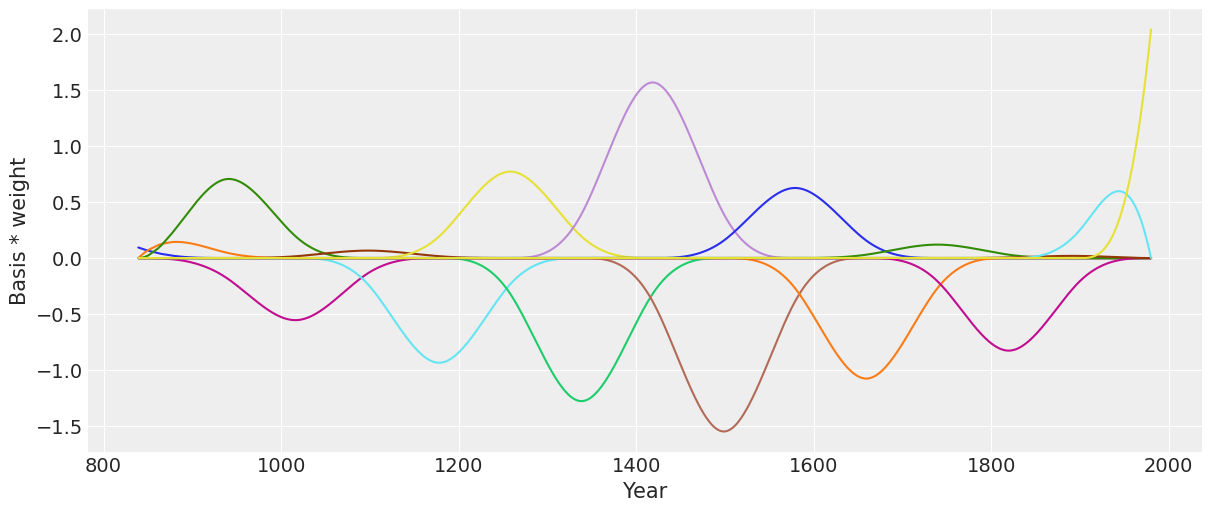

In [17]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(df['year'], w_means * B)

ax.set_xlabel('Year')
ax.set_ylabel('Basis * weight')

plt.show()

### Plotting the Mean $\mu$ values 

In [18]:
temp_post_samples = pm.sampling.sample_posterior_predictive(trace=trace_4_7, samples=5000, model=m_4_7)

temp_simulated = temp_post_samples['temp']

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


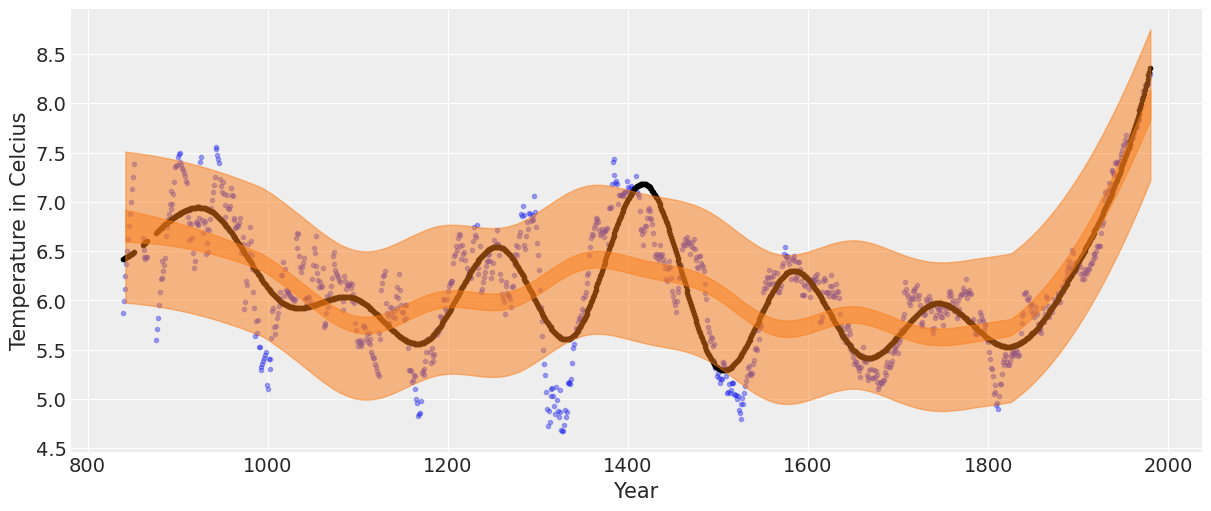

In [19]:
df_mu = df_trace.filter(regex=('mu.*'))
mu_mean = df_mu.apply(np.mean, axis=0)

yr = df['year']
temp = df['temp']


_, ax = plt.subplots(1, 1, figsize=(12, 5))

# year and temp 
ax.scatter(yr, temp, marker='.', alpha=0.4)

# year vs the mean value for that year, the mean being computed across all samples 
ax.scatter(yr, mu_mean, color='k', marker='.')

# Bayesian highest density interval with a probability of 97%
az.plot_hdi(x=yr, y=np.expand_dims(df_mu.values, 0), hdi_prob=0.97, ax=ax)

# Plot the hpd intervals for temperature 
az.plot_hdi(x=yr, y=np.expand_dims(temp_simulated, 0), hdi_prob=0.97, ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel(r'Temperature in Celcius')

plt.show()